Name: Arya Araban -- Student id: 1439683

In [ ]:
import numpy as np
from scipy import linalg
from scipy import sparse

!pip install osqp
import osqp

import matplotlib.pyplot as plt

# Part A: Construct the matrices

This code defines and sets up the parameters, constraints, and matrices for an optimization problem involving a system with state and action vectors. It constructs the necessary matrices and vectors for solving the optimization problem.

In [ ]:


"""
Defining the parameters as variables
"""




# Time increment of the discrete-time dynamics matrices (units: seconds)
# > Also called the "sample time" and often denoted as Ts
Ts = 0.1

# Dynamics matrices

A = sparse.csc_matrix([
    [1., 0., Ts, 0.],
    [0., 1., 0., Ts],
    [0., 0., 1., 0.],
    [0., 0., 0., 1.]
], dtype=np.float32)


B = sparse.csc_matrix([
    [0.5 * Ts * Ts, 0.],
    [0., 0.5 * Ts * Ts],
    [Ts, 0.],
    [0., Ts]
], dtype=np.float32)


# Determine the number of states and actions
n_s = A.shape[1]
n_a = B.shape[1]


# Randomly generate Initial state
s_initial = np.random.uniform(
    low  = -1*np.ones((n_s,1)),
    high =  1*np.ones((n_s,1)),
    size = (n_s,1)
)


# Objective matrices
Q = sparse.diags([1., 1., 1., 1.], format="csc", dtype=np.float32)
R = sparse.diags([1., 1.], format="csc", dtype=np.float32)


# Terminal-objective matrices

# Same as per-stage objective -- WE USE THIS out of 4 options
P_dense = Q.toarray()

# Convert P to be in sparse format
P = sparse.csc_matrix(P_dense, shape=(n_s,n_s), dtype=np.float32)

# Box constraints
# > Note: use np.inf for any unconstrained elements
s_lower = np.array([[-2.0], [-2.0], [-np.infty], [-np.infty]]) #x-loc, y-loc, x_vel, y_vel
s_upper = np.array([[ 2.0], [ 2.0], [ np.infty], [ np.infty]])
a_lower = np.array([[-0.5], [-0.5]]) #Force x, Force y
a_upper = np.array([[ 0.5], [ 0.5]])


"""
Constructing the matrices for the optimization problem
"""

def OSQP_parameters(N,P):
  """ OSQP paremeters.
      inputs: N (horizon length) & P (objective function)
      constructs related matrices and returns the parameters reuqired for the OSQP solver
  """
  # Matrix for all time steps of the dynamics
  AB = sparse.hstack([A,B])

  negI_zero_block = sparse.hstack([ -sparse.eye(n_s,format="csc") , sparse.csc_matrix((n_s,n_a)) ])
  zero_negI_col = sparse.vstack([sparse.csc_matrix(((N-1)*n_s,n_s)),-sparse.eye(n_s,format="csc")])
  ABI_stacked = \
      sparse.hstack([ sparse.kron(sparse.eye(N,format="csc") , AB) , sparse.csc_matrix((N*n_s,n_s)) ]) \
      + \
      sparse.hstack([ sparse.kron(sparse.eye(N,k=1,format="csc"),negI_zero_block) , zero_negI_col ])

  # Matrix for selecting the first state
  s0_selector = sparse.hstack([ sparse.eye(n_s,format="csc"),sparse.csc_matrix((n_s,N*(n_s+n_a))) ])

  # Stacking the above two together
  Aeq = sparse.vstack([ s0_selector , ABI_stacked ])


  # Vector for equality constraint
  # > Note: this vector needs to be updated every time we get a new measurement of the current state.
  beq = np.vstack([ s_initial , np.zeros((N*n_s,1)) ])

  # Objective function matrix
  QR = sparse.block_diag([Q,R])
  H  = sparse.block_diag([ sparse.kron(sparse.eye(N,format="csc"),QR), P ],format="csc")

  # Lower and upper bounds of box constraints
  sa_lower = np.vstack([ s_lower , a_lower ])
  sa_upper = np.vstack([ s_upper , a_upper ])
  x_lower = np.vstack([ np.kron(np.ones((N,1),dtype=np.float32),sa_lower), s_lower ])
  x_upper = np.vstack([ np.kron(np.ones((N,1),dtype=np.float32),sa_upper), s_upper ])

  # Build the constraint matrix for OSQP format
  A_for_osqp = sparse.vstack([ Aeq , sparse.eye(N*(n_s+n_a)+n_s,format="csc") ],format="csc")

  # Build the constraint vectors for OSQP format
  l_for_osqp = np.vstack([ beq , x_lower ])
  u_for_osqp = np.vstack([ beq , x_upper ])

  p_for_osqp = 2*H
  q_for_osqp = np.zeros(H.shape[1])


  return A_for_osqp, l_for_osqp, u_for_osqp, p_for_osqp, q_for_osqp



#Part B: Pass matrices to solver and interrogate the results

In [ ]:

"""
Solving the optimization problem using OSQP solver
"""
N = 10  # horizon length

# Same as per-stage objective -- WE USE THIS out of 4 options
P_dense = Q.toarray()
# Convert P to be in sparse format
P = sparse.csc_matrix(P_dense, shape=(n_s,n_s), dtype=np.float32)

A_for_osqp, l_for_osqp, u_for_osqp, p_for_osqp, q_for_osqp = OSQP_parameters(N,P)


# Initialize an OSQP object
osqp_obj = osqp.OSQP()


# Setup the parameters of the optimization program
osqp_obj.setup(
    A=A_for_osqp,
    l=l_for_osqp,
    u=u_for_osqp,
    P=p_for_osqp,
    q=q_for_osqp,
    verbose=False,
    #warm_starting=True,
)

# Solve the optimization program
osqp_results = osqp_obj.solve()


"""interrogating results"""

# Extract the status string
osqp_status_string = osqp_results.info.status

# Display the status if it is anything other than success
if (osqp_status_string != "solved"):
      raise ValueError("OSQP did not solve the problem, returned status = " + osqp_status_string)

# Extract the optimal solution
x_optimal = osqp_results.x

# Extract the first action from the optimal solution
a0 = x_optimal[(n_s+1):(n_s+n_a)]

# Extract the overall solver time
osqp_run_time = osqp_results.info.run_time

# Display some minimal information
print("OSQP successfully solved in " + str(osqp_run_time) + " seconds.")


OSQP successfully solved in 0.000246324 seconds.


#Part C: Simulate closed-loop trajectories of the MPC policy

In [ ]:
def perform_simulation(N_sim, osqp_obj, print_info=False):
    # Specify the time-increment of the simulation (units: seconds)
    Ts_sim = Ts

    # Construct a vector of the times
    time_values = np.arange(start=0, stop=(N_sim+0.5)*Ts_sim, step=Ts_sim, dtype=np.float32)

    # Get size of the optimization variable
    n_x_opt = p_for_osqp.shape[1]

    # Pre-allocate matrices for storing the results
    state_trajectory = np.empty((n_s,N_sim+1), dtype=np.float32)
    action_trajectory = np.empty((n_a,N_sim), dtype=np.float32)
    x_optimal_trajectory = np.empty((n_x_opt,N_sim), dtype=np.float32)
    solver_run_times = np.empty(N_sim, dtype=np.float32)
    solve_status_val = np.empty(N_sim, dtype=np.int32)

    # Set the initial condition
    state_trajectory[:,0] = s_initial[:,0]

    # Initialise a variable for the current state
    s_current = s_initial

    # Initialise a variable for the current action
    a_current = np.empty((n_a,1), dtype=np.float32)

    # Display some information before starting sim loop
    if print_info:
      print("Now starting simulation for " + str(N_sim) + " discrete time steps of the closed-loop MPC policy (i.e., simulating " + str(N_sim*Ts_sim) + " seconds at sample time of " + str(Ts_sim) + " seconds)")

    # SIM LOOP START
    # Iterate over the simulation time step
    for i_time in np.arange(0,N_sim):
        # Update the constraint vector with the current state
        l_for_osqp[0:n_s] = s_current
        u_for_osqp[0:n_s] = s_current

        # Update the OSQP object with the current state
        osqp_obj.update(l=l_for_osqp, u=u_for_osqp)

        # Solve the optimization program
        osqp_result = osqp_obj.solve()

        # Extract the status string
        osqp_status_string = osqp_result.info.status

        # Display the status if it is anything other than success
        if (osqp_status_string != "solved"):
            raise ValueError("OSQP did not solve the problem, returned status = " + osqp_status_string)

        # Extract the optimal solution
        x_optimal = osqp_result.x

        # Extract the first action from the optimal solution
        a_current[:,0] = x_optimal[n_s:(n_s+n_a)]

        # Compute the next state
        s_next = A @ s_current + B @ a_current

        # Store the results
        state_trajectory[:,i_time+1] = s_next[:,0]
        action_trajectory[:,i_time]  = a_current[:,0]
        x_optimal_trajectory[:,i_time] = x_optimal
        solver_run_times[i_time] = osqp_result.info.run_time
        solve_status_val[i_time] = osqp_result.info.status_val

        # Iterate the state
        s_current = s_next

    # SIM LOOP END

    # Display some information after sim loop ends
    print("Simulation complete.")

    # Display some statistics of the solve time
    temp_min = np.min( solver_run_times, axis=None)
    temp_median = np.median( solver_run_times, axis=None)
    temp_mean = np.mean( solver_run_times, axis=None) #average solve time. this will be used in next parts
    temp_max = np.max( solver_run_times, axis=None)
    temp_std = np.std( solver_run_times, axis=None)
    if print_info:
      print("Solve time {min, median, mean, max, stddev} = {" + str(temp_min) + " , " + str(temp_median) + " , " + str(temp_mean) + " , " + str(temp_max) + " , " + str(temp_std) + " }")

    return state_trajectory, action_trajectory, x_optimal_trajectory, n_x_opt, time_values, temp_mean



# Call this function to perform simulation for N_sim time steps.
N_sim = 120
state_trajectory, action_trajectory, x_optimal_trajectory, n_x_opt, time_values, _ = perform_simulation(N_sim, osqp_obj)

Simulation complete.


Visualization

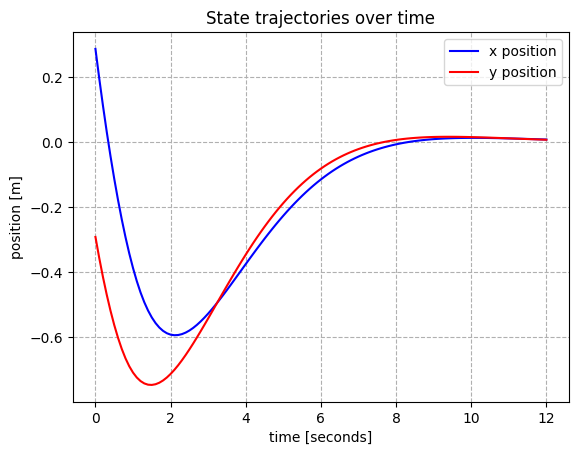

In [ ]:
# ================
# PLOT THE RESULTS

# Plot state trajectories over time
# > Open a figure
fig1, ax1 = plt.subplots()
# > Plot the results
x_position_traj = state_trajectory[0,:]
y_position_traj = state_trajectory[1,:]
ax1.plot(time_values,x_position_traj,color="blue",label="x position")
ax1.plot(time_values,y_position_traj,color="red", label="y position")
# > Make the plot intelligible
ax1.set_xlabel('time [seconds]')
ax1.set_ylabel('position [m]')
ax1.legend(loc = 'upper right')
ax1.set_title('State trajectories over time')
ax1.grid(visible=True, which="both", axis="both", linestyle='--')


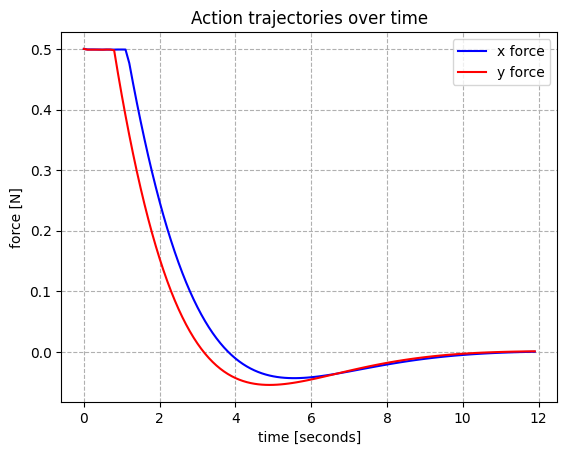

In [ ]:
# Plot action trajectories over time
# > Open a figure
fig2, ax2 = plt.subplots()
# > Plot the results
ax2.plot(time_values[0:N_sim],action_trajectory[0,:],color="blue",label="x force")
ax2.plot(time_values[0:N_sim],action_trajectory[1,:],color="red", label="y force")
# > Make the plot intelligible
ax2.set_xlabel('time [seconds]')
ax2.set_ylabel('force [N]')
ax2.legend(loc = 'upper right')
ax2.set_title('Action trajectories over time')
ax2.grid(visible=True, which="both", axis="both", linestyle='--')


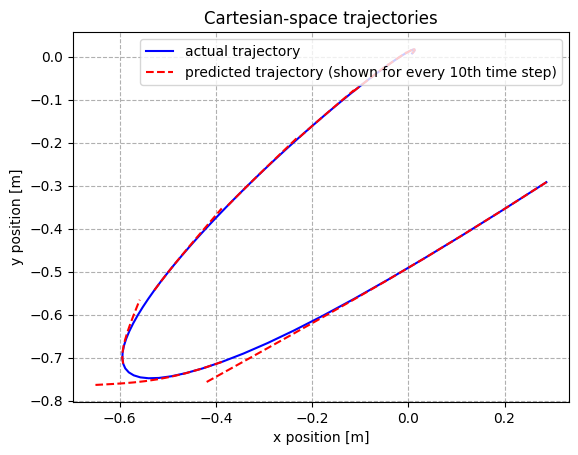

In [ ]:
# Plot the trajectory and predictions in the Cartesian space
# > Open a figure
fig3, ax3 = plt.subplots()
# > Plot the actual trajectory results
x_position_traj = state_trajectory[0,:]
y_position_traj = state_trajectory[1,:]
ax3.plot(x_position_traj,y_position_traj,color="blue",label="actual trajectory")
# > Plot the MPC prediction at multiple steps
for k_step in np.arange(start=0, stop=N_sim-1, step=10):
    # > Construct indexing for retrieving the predictions
    x_idx = np.array(np.arange(0,n_x_opt,n_s+n_a,dtype=np.int32))
    y_idx = np.array(np.arange(1,n_x_opt,n_s+n_a,dtype=np.int32))
    k_idx = np.array(k_step,dtype=np.int32)
    # > Plot the predictions
    x_predictions = x_optimal_trajectory[x_idx,k_idx]
    y_predictions = x_optimal_trajectory[y_idx,k_idx]
    hplot, = ax3.plot(x_predictions,y_predictions,color="red",linestyle='dashed')
    # > Add a legend label only to the first line
    if (k_step == 0):
        hplot.set_label("predicted trajectory (shown for every 10th time step)")
# > Make the plot intelligible
ax3.set_xlabel('x position [m]')
ax3.set_ylabel('y position [m]')
ax3.legend(loc = 'upper right')
ax3.set_title('Cartesian-space trajectories')
ax3.grid(visible=True, which="both", axis="both", linestyle='--')

#Part D: Horizon length versus computation time and performance.

ASSUMPTIONS:

• Objective (Q) = Sparse identity Matrix (4)

• Objective (R) = Sparse identity Matrix (2)

• Terminal Objective is per stage

• Number of Simulations per variation (N_sim) = 100

• Average time across simulations used as time metric

In [153]:
# Set up different horizon lengths to test
N_values = [5, 10, 15, 20, 25, 30, 35, 40]

# Initialize arrays to store results
solver_times = []
performances = []

n_x_opts = []
x_optimal_trajectories = []

# Same as per-stage objective -- WE USE THIS out of 4 options
P_dense = Q.toarray()
# Convert P to be in sparse format
P = sparse.csc_matrix(P_dense, shape=(n_s,n_s), dtype=np.float32)


for N in N_values:
  # Update horizon length
  N = N

  A_for_osqp, l_for_osqp, u_for_osqp, p_for_osqp, q_for_osqp = OSQP_parameters(N,P)


  # Initialize OSQP solver object (from Part B)
  osqp_obj = osqp.OSQP()

  # Setup the parameters of the optimization program
  osqp_obj.setup(
      A=A_for_osqp,
      l=l_for_osqp,
      u=u_for_osqp,
      P=p_for_osqp,
      q=q_for_osqp,
      verbose=False,
      #warm_starting=True,
  )

  # Simulate MPC policy (Part C)
  N_sim = 100
  state_trajectory, action_trajectory, x_optimal_trajectory, n_x_opt, time_values, avg_solve_time = perform_simulation(N_sim, osqp_obj)

  solver_times.append(avg_solve_time)

  n_x_opts.append(n_x_opt)
  x_optimal_trajectories.append(x_optimal_trajectory)

  # performance metric
  performance = 0
  for k in range(N_sim):
    performance += state_trajectory[:, k].T @ Q @ state_trajectory[:, k] + action_trajectory[:, k].T @ R @ action_trajectory[:, k]

  performances.append(performance)

# print(performances)

Simulation complete.
Simulation complete.
Simulation complete.
Simulation complete.
Simulation complete.
Simulation complete.
Simulation complete.
Simulation complete.


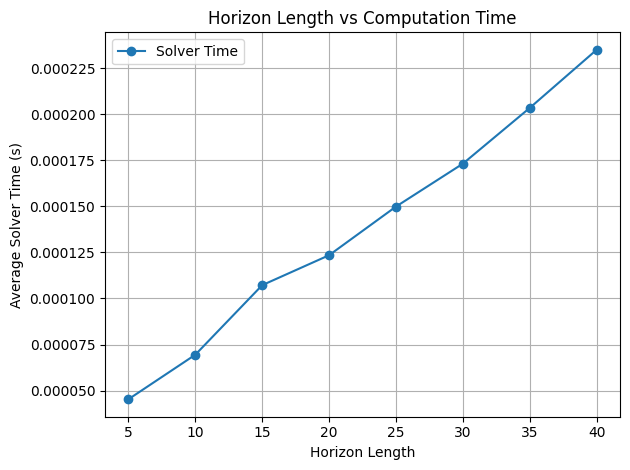

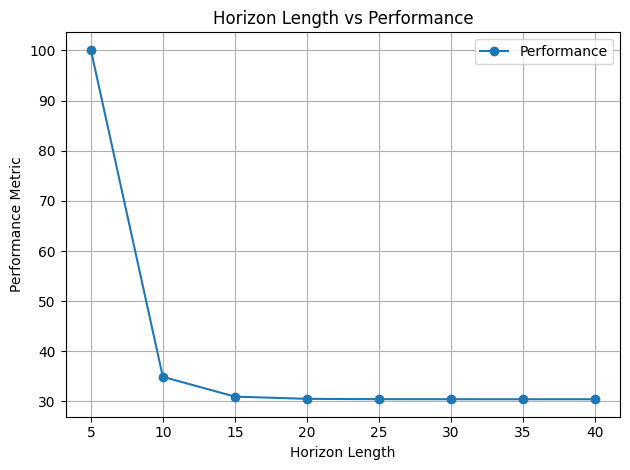

In [ ]:
# Plot horizon length vs compute time
fig, ax = plt.subplots()
ax.plot(N_values, solver_times, '-o', label='Solver Time')
ax.set_xlabel('Horizon Length')
ax.set_ylabel('Average Solver Time (s)')
ax.set_title('Horizon Length vs Computation Time')
ax.legend()  # Add legend
ax.grid(True)  # Add gridlines

plt.tight_layout()
plt.show()



# # Print correspondence table for compute time
# table_data = [['Horizon Length', 'Solver Time']]
# for n, time in zip(N_values, solver_times):
#     table_data.append([str(n), str(time)])

# print(table_data)

# Plot horizon length vs performance
fig, ax = plt.subplots()
ax.plot(N_values, performances, '-o', label='Performance')
ax.set_xlabel('Horizon Length')
ax.set_ylabel('Performance Metric')
ax.set_title('Horizon Length vs Performance')
ax.legend()  # Add legend
ax.grid(True)  # Add gridlines

plt.tight_layout()
plt.show()

# # Print correspondence table for performance
# table_data = [['Horizon Length', 'Performance']]
# for n, perf in zip(N_values, performances):
#     table_data.append([str(n), str(perf)])

# print(table_data)

The results show a steady increase in computation time as the prediction horizon length increases, with a roughly linear relationship. However, there is a significant improvement in tracking performance when increasing the horizon from 5 to 10 steps, indicating that a longer horizon is necessary for good performance (note that increasing performance means lowering the utilized metric). Beyond 10 steps, the performance metric continues to decrease, but with diminishing returns. By around 25 steps, the performance plateaus, suggesting that further increases in horizon length do not provide significant benefits.

<br>

These results highlight the trade-off between horizon length, computational load, and closed-loop performance. While longer horizons lead to better performance, they also increase computation time. Therefore, it is important to choose a sufficiently long horizon to achieve good performance while avoiding excessively long horizons that can lead to solve time issues.

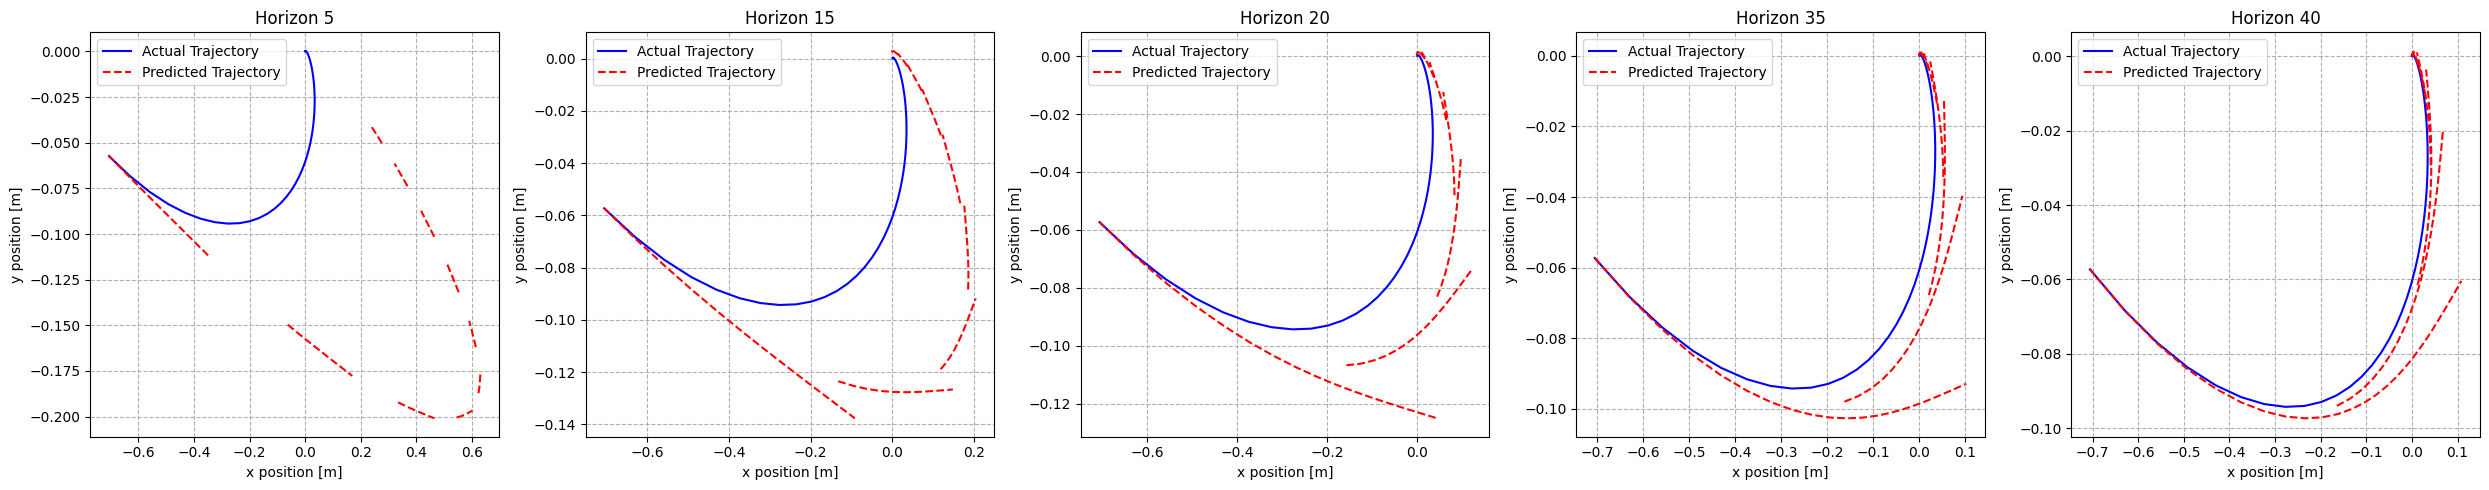

In [ ]:
horizons_to_show = [5, 15, 20, 35, 40]

# Create a grid of subplots
num_plots = len(horizons_to_show)
fig, axs = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5))

# Plot the actual trajectory in each subplot
for i in range(num_plots):
    ax = axs[i]
    ax.plot(state_trajectory[0, :], state_trajectory[1, :], color="blue", label="Actual Trajectory")
    ax.set_xlabel('x position [m]')
    ax.set_ylabel('y position [m]')
    ax.set_title(f"Horizon {horizons_to_show[i]}")
    ax.grid(visible=True, which="both", axis="both", linestyle='--')

    # Plot the corresponding predicted trajectory
    for k_step in np.arange(start=0, stop=N_sim-1, step=10):
        # predicted trajectory is shown for every 10th time step
        x_idx = np.arange(0, n_x_opts[i], n_s+n_a, dtype=np.int32)
        y_idx = np.arange(1, n_x_opts[i], n_s+n_a, dtype=np.int32)
        k_idx = np.array(k_step, dtype=np.int32)
        x_predictions = x_optimal_trajectories[i][x_idx, k_idx]
        y_predictions = x_optimal_trajectories[i][y_idx, k_idx]

        label = "Predicted Trajectory" if k_step == 0 else None
        ax.plot(x_predictions, y_predictions, color="red", linestyle='dashed', label=label)

    ax.legend()  # Add legend to each subplot

plt.tight_layout()
plt.show()

The plots show that with a short prediction horizon of 5 steps, the MPC controller produces poor state predictions that deviate significantly from the actual closed-loop trajectories. As the horizon length increases, the accuracy of the predicted trajectories improves rapidly, with the predictions closely matching the actual trajectories by moderately long horizons. However, As discussed previously, the performance results showed diminishing returns and a plateauing with longer horizons. This discrepancy suggests the predicted trajectories continue improving even after the performance gains have tapered off, with a potential explanation bieng that reasonably accurate predictions are possible before maximum performance is achieved.

#Part E: Objective function weights on position versus velocity states, and on state weights versus action weights.

ASSUMPTIONS:

• Horizon Length (N) = 100

• Number of simulations per variation (N_sim) = 100



In [159]:
#parameters
N = 100 #horizon

n_s = 4
n_a = 2

s_initial = np.random.uniform(
    low  = -1*np.ones((n_s,1)),
    high =  1*np.ones((n_s,1)),
    size = (n_s,1)
)


# Weights to test

weights = [[1, 0.1, 0], [10, 0.1, 0], [0.1, 10, 0], [1, 1, 0], [100, 1, 1], [0.1, 100, 10]]  # pos_weights, vel_weights, alpha_values
# [1, 0.1, 0]: Equal weights for position and velocity, no weight for alpha.
# [10, 0.1, 0]: Higher weight for position, small weight for velocity, no weight for alpha.
# [0.1, 10, 0]: Small weight for position, higher weight for velocity, no weight for alpha.
# [1, 1, 0]: Equal weights for position and velocity, no weight for alpha.
# [100, 1, 1]: Very high weight for position, small weight for velocity, small weight for alpha.
# [0.1, 100, 10]: Small weight for position, very high weight for velocity, higher weight for alpha.


# Initialize metric arrays
overshoots = []
settling_times = []
action_mags = []
action_changes = []


for values in weights:

  pos_weight = values[0]
  vel_weight = values[1]
  alpha = values[2]

  Q = sparse.diags([pos_weight, pos_weight, vel_weight, vel_weight], format="csc")

  R = alpha * np.eye(2)

  # Generate MPC matrices
  A_for_osqp, l_for_osqp, u_for_osqp, p_for_osqp, q_for_osqp = OSQP_parameters(N, P)

  # Create and setup OSQP solver
  osqp_obj = osqp.OSQP()
  osqp_obj.setup(A=A_for_osqp, l=l_for_osqp, u=u_for_osqp, P=p_for_osqp, q=q_for_osqp, verbose=False)

  N_sim = 100
  state_trajectory, action_trajectory, x_optimal_trajectory, n_x_opt, time_values, avg_solve_time = perform_simulation(N_sim, osqp_obj)

  # Compute and store metrics
  overshoot = max(abs(state_trajectory[0,:]))

  settling_time = np.argmax(np.abs(state_trajectory[0,:]) < 0.1)

  action_mag = np.sum(np.abs(action_trajectory))

  action_change = np.max(np.diff(action_trajectory, axis=1))

  overshoots.append(overshoot)
  settling_times.append(settling_time)
  action_mags.append(action_mag)
  action_changes.append(action_change)


Simulation complete.
Simulation complete.
Simulation complete.
Simulation complete.
Simulation complete.
Simulation complete.


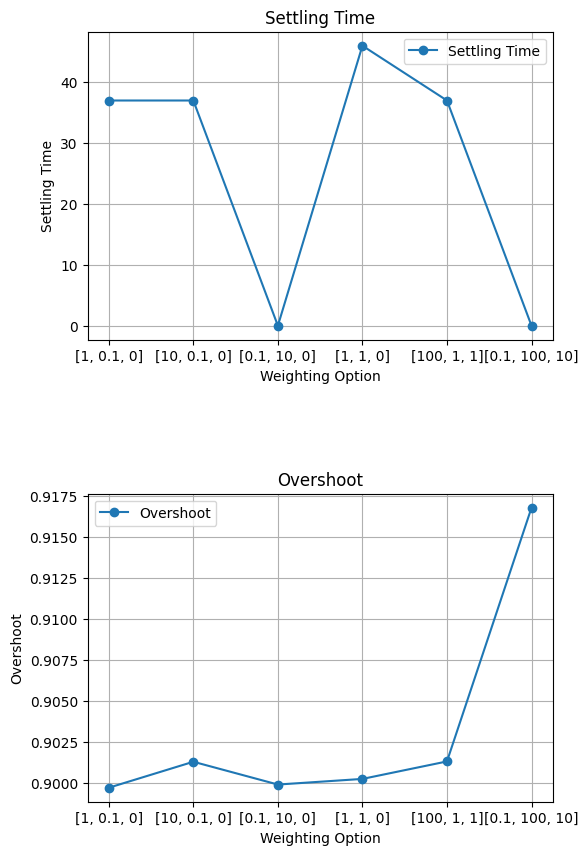

In [147]:
fig, axs = plt.subplots(2, 1, figsize=(6, 10))

# Plot settling_times
axs[0].plot(range(len(weights)), settling_times, '-o')
axs[0].set_xticks(range(len(weights)))
axs[0].set_xticklabels(weights)
axs[0].set_xlabel('Weighting Option')
axs[0].set_ylabel('Settling Time')
axs[0].set_title('Settling Time')
axs[0].legend(['Settling Time'])
axs[0].grid(True)

# Plot overshoots
axs[1].plot(range(len(weights)), overshoots, '-o')
axs[1].set_xticks(range(len(weights)))
axs[1].set_xticklabels(weights)
axs[1].set_xlabel('Weighting Option')
axs[1].set_ylabel('Overshoot')
axs[1].set_title('Overshoot')
axs[1].legend(['Overshoot'])
axs[1].grid(True)

plt.subplots_adjust(hspace=0.5)
plt.show()

The settling time metric is strongly dependent on the position weight in the Q matrix. When the position weight is low, the settling time drops to 0, indicating that the system never reaches the settled threshold. This is because with low position weighting, the controller objective does not adequately penalize large position deviations. On the other hand, the overshoot metric is most affected by the R matrix weighting α. Overshoot increases significantly when α is raised, meaning the actions are weighted more heavily. This causes the controller to use smaller, less aggressive actions to minimize the objective function.

<br>

These results demonstrate that the Q matrix weights guide the controller to achieve the desired state performance, while the R matrix weights shape the aggressiveness of the actions. Tuning these weights provides a tradeoff between control objectives like settling time versus smoother actions and less overshoot.


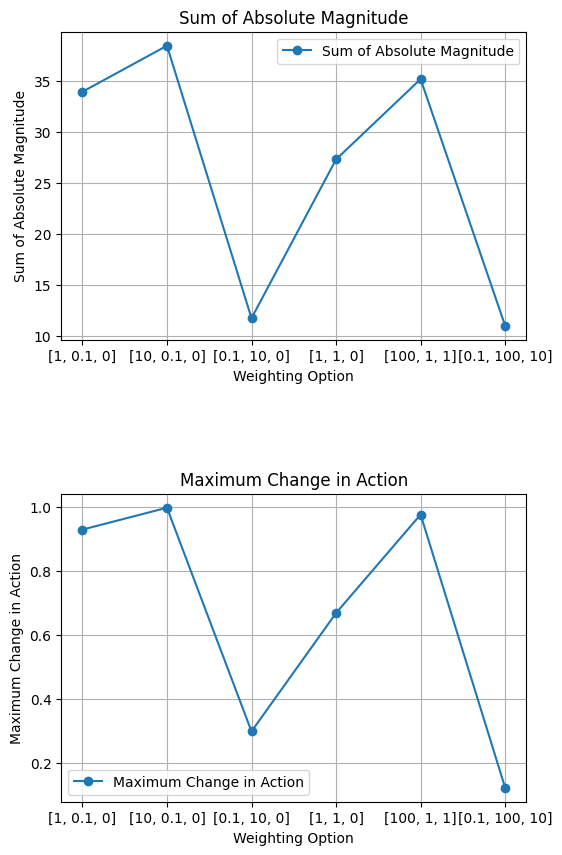

In [148]:
# Create a new figure and axes for the last two plots
fig2, axs2 = plt.subplots(2, 1, figsize=(6, 10))

# Plot sum_of_absolute_magnitude
axs2[0].plot(range(len(weights)), action_mags, '-o')
axs2[0].set_xticks(range(len(weights)))
axs2[0].set_xticklabels(weights)
axs2[0].set_xlabel('Weighting Option')
axs2[0].set_ylabel('Sum of Absolute Magnitude')
axs2[0].set_title('Sum of Absolute Magnitude')
axs2[0].legend(['Sum of Absolute Magnitude'])
axs2[0].grid(True)

# Plot maximum_change_in_action
axs2[1].plot(range(len(weights)), action_changes, '-o')
axs2[1].set_xticks(range(len(weights)))
axs2[1].set_xticklabels(weights)
axs2[1].set_xlabel('Weighting Option')
axs2[1].set_ylabel('Maximum Change in Action')
axs2[1].set_title('Maximum Change in Action')
axs2[1].legend(['Maximum Change in Action'])
axs2[1].grid(True)

plt.subplots_adjust(hspace=0.5)
plt.show()

From these results it can be seen that emphasizing position weight in the control objective leads to more aggressive actions with larger variations. This is because a high weight on positional deviation pushes the controller to make larger corrections to minimize error. On the other hand, focusing on velocity weights produces smoother control behavior. The controller becomes more concerned with managing the rate of change rather than instant position. This allows it to make smaller, more measured inputs that reduce total effort and maximum action changes.

<br>

The relative weighting of states versus actions also significantly impacts control aggressiveness. With no cost on actions (α=0), the controller freely exploits large inputs to optimize state performance. But as the action cost increases, the optimization becomes more conservative to avoid large control efforts. This results in smaller overall magnitudes and variations in the action trajectories.

#Part F: Terminal objective options.

ASSUMPTIONS:

• Horizon Length (N) = 5

• Objective (Q) = Sparse identity Matrix (4)

• Objective (R) = Sparse identity Matrix (2)

• Number of simulations per variation (N_sim) = 100

• Average time across simulations used as time metric

In [ ]:
"""Re-Set the variables so we are sure the values are correct: """

# Dynamics matrices

# Horizon length
N = 5

A = sparse.csc_matrix([
    [1., 0., Ts, 0.],
    [0., 1., 0., Ts],
    [0., 0., 1., 0.],
    [0., 0., 0., 1.]
], dtype=np.float32)


B = sparse.csc_matrix([
    [0.5 * Ts * Ts, 0.],
    [0., 0.5 * Ts * Ts],
    [Ts, 0.],
    [0., Ts]
], dtype=np.float32)


# Determine the number of states and actions
n_s = A.shape[1]
n_a = B.shape[1]

# Objective matrices
Q = sparse.diags([1., 1., 1., 1.], format="csc", dtype=np.float32)
R = sparse.diags([1., 1.], format="csc", dtype=np.float32)






# Terminal cost options
P_options = [sparse.csc_matrix(np.zeros_like(Q.toarray())), Q.toarray(), linalg.solve_discrete_are(A.toarray(),B.toarray(),Q.toarray(),R.toarray())]

# Initialize arrays
solver_times = []
performances = []

n_x_opts = []
x_optimal_trajectories = []


for P in P_options:


  # Set terminal cost matrix
  P_dense = P

  # Set up MPC matrices
  A_for_osqp, l_for_osqp, u_for_osqp, p_for_osqp, q_for_osqp = OSQP_parameters(N, P)

  # Create OSQP solver
  osqp_obj = osqp.OSQP()
  osqp_obj.setup( A=A_for_osqp,
      l=l_for_osqp,
      u=u_for_osqp,
      P=p_for_osqp,
      q=q_for_osqp,
      verbose=False,)

  # Simulate MPC
  N_sim = 100
  state_trajectory, action_trajectory, x_optimal_trajectory, n_x_opt, time_values, avg_solve_time = perform_simulation(N_sim, osqp_obj)

  # Store results
  solver_times.append(avg_solve_time)

  # Compute performance
  performance = 0
  for k in range(N_sim):
    performance += state_trajectory[:,k].T @ Q @ state_trajectory[:,k] + action_trajectory[:,k].T @ R @ action_trajectory[:,k]

  n_x_opts.append(n_x_opt)
  x_optimal_trajectories.append(x_optimal_trajectory)

  performances.append(performance)
solver_times_cp = solver_times
print(solver_times)

print(performances)

[4.7511083e-05, 4.9065995e-05, 4.8461304468219167e-05]
[220.75501543283463, 128.2690183967352, 38.53103283074324]


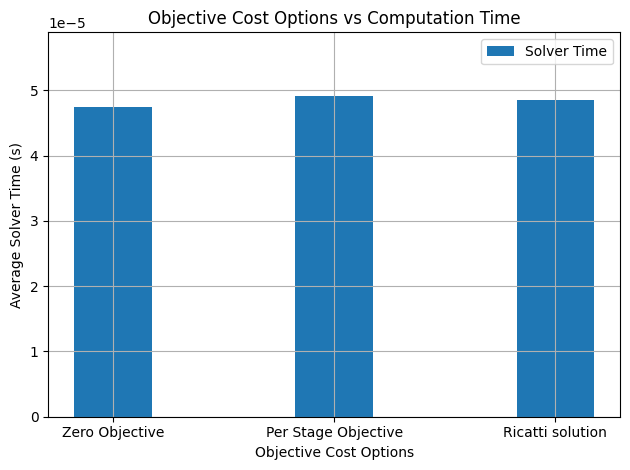

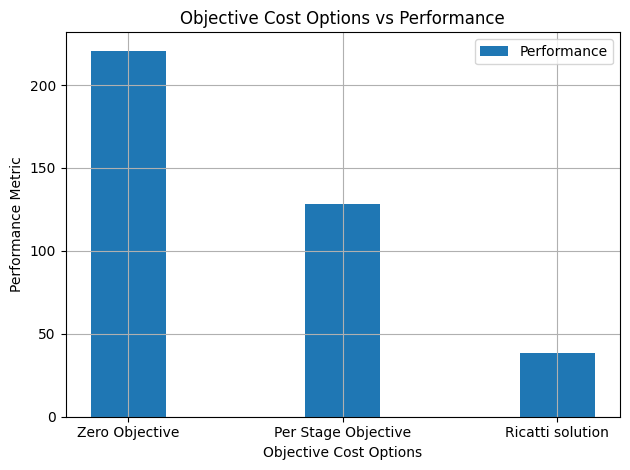

In [ ]:
# Data for the terminal cost options
terminal_objective_options = ['Zero Objective', 'Per Stage Objective', 'Ricatti solution']


# Plot grouped bar plot for solver times
fig, ax = plt.subplots()
bar_width = 0.35
index = np.arange(len(terminal_objective_options))
ax.bar(index, solver_times, bar_width, label='Solver Time')
ax.set_xlabel('Objective Cost Options')
ax.set_ylabel('Average Solver Time (s)')
ax.set_ylim(0, max(solver_times) * 1.2)
ax.set_title('Objective Cost Options vs Computation Time')
ax.set_xticks(index)
ax.set_xticklabels(terminal_objective_options)
ax.legend()  # Add legend
ax.grid(True)  # Add gridlines
plt.tight_layout()
plt.show()

# Plot grouped bar plot for performances
fig, ax = plt.subplots()
ax.bar(index, performances, bar_width, label='Performance')
ax.set_xlabel('Objective Cost Options')
ax.set_ylabel('Performance Metric')
ax.set_title('Objective Cost Options vs Performance')
ax.set_xticks(index)
ax.set_xticklabels(terminal_objective_options)
ax.legend()  # Add legend
ax.grid(True)  # Add gridlines
plt.tight_layout()
plt.show()

The MPC results demonstrate significant variations in performance among the three terminal cost options, despite their similar solver times. The use of a zero terminal cost leads to notably inferior performance compared to the per-stage cost Q. This discrepancy arises because a zero terminal cost fails to incentivize driving the states towards the origin at the end of the prediction horizon, focusing solely on minimizing stage costs throughout the horizon.

<br>

Conversely, employing the Riccati optimal terminal cost solution yields substantial performance improvements, achieving over 5 times better results than the zero terminal cost. The Riccati solution incorporates system dynamics and desired objectives to derive an optimal terminal cost matrix P. This matrix captures valuable information on how to effectively steer the states towards the origin. By utilizing this enhanced terminal cost, which aligns with the true objective, the MPC controller can compute superior actions that decrease the stage costs throughout the horizon.

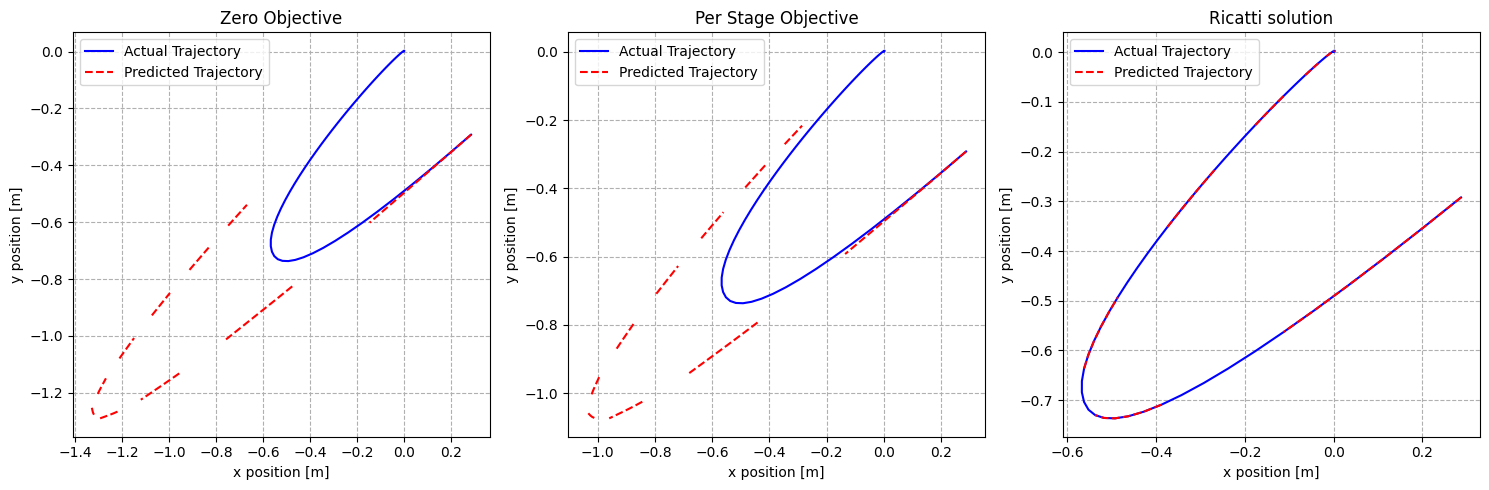

In [ ]:
# Create a grid of subplots
num_plots = len(terminal_objective_options)
fig, axs = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5))

# Plot the actual trajectory in each subplot
for i in range(num_plots):
    ax = axs[i]
    ax.plot(state_trajectory[0, :], state_trajectory[1, :], color="blue", label="Actual Trajectory")
    ax.set_xlabel('x position [m]')
    ax.set_ylabel('y position [m]')
    ax.set_title(f"{terminal_objective_options[i]}")
    ax.grid(visible=True, which="both", axis="both", linestyle='--')

    # Plot the corresponding predicted trajectory
    for k_step in np.arange(start=0, stop=N_sim-1, step=10):
        # predicted trajectory is shown for every 10th time step
        x_idx = np.arange(0, n_x_opts[i], n_s+n_a, dtype=np.int32)
        y_idx = np.arange(1, n_x_opts[i], n_s+n_a, dtype=np.int32)
        k_idx = np.array(k_step, dtype=np.int32)
        x_predictions = x_optimal_trajectories[i][x_idx, k_idx]
        y_predictions = x_optimal_trajectories[i][y_idx, k_idx]

        label = "Predicted Trajectory" if k_step == 0 else None
        ax.plot(x_predictions, y_predictions, color="red", linestyle='dashed', label=label)

    ax.legend()  # Add legend to each subplot

plt.tight_layout()
plt.show()

The predicted trajectories provide further insight into the performance differences between the terminal cost options. With a zero terminal cost, the predicted states deviate significantly from the actual trajectory, indicating that the MPC controller is unable to predict the state evolution well with this simplistic terminal cost. For the per-stage cost, the predictions are improved but still exhibit noticeable differences from the actual trajectory. In contrast, the predicted trajectory with the Riccati optimal terminal cost overlays the actual trajectory almost exactly throughout the horizon, demonstrating that the Riccati solution enables the MPC controller to predict the state evolution very accurately by deriving a terminal cost tailored to the dynamics and control objective. The inaccurate predictions with more simplistic terminal costs lead to poorer control actions and therefore worse closed-loop performance.